In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
import imageio
from pathlib import Path
import warnings

In [734]:
file_path = '/Volumes/KESU/IRCAM_data/jun282021/'
name = "face.h5"
name_dark = 'cold_vert1.h5'

In [735]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

mask = create_circular_mask(256, 320,radius = 150);

In [736]:
hf = h5py.File(file_path+name, 'r')
hfdark = h5py.File(file_path+name_dark, 'r')
imgs = np.array(hf['imgs'])
ts  = np.array(hf['temps'])
ans = np.array(hf['set_angels'])
dark = np.array(hfdark['imgs'])

ims = []
for i in range(len(imgs)):
    img_mask = (imgs[i]-dark[i]+.001)*mask 
    img_mask[img_mask == 0] = 'nan' 
    ims.append(img_mask)
    imgs[i] = imgs[i]-dark[i]
    
#imgs[imgs < 0] = 0

S0 = np.sum(imgs,axis = 0)/2
S1 = imgs[0]-imgs[2]
S2 = imgs[1]-imgs[3]

s1 = S1/S0
s2 = S2/S0

DOLP = 100*np.sqrt(S1**2+S2**2)/S0
AOLP = 180/ (2*np.pi*np.arctan2 (S2,S1))

In [742]:
vmax = np.nanmax(ims[0])
vmin = 1200#np.nanmin(ims[0])
s1vmax = np.max(np.abs(S1))
s2vmax = np.max(np.abs(S2))

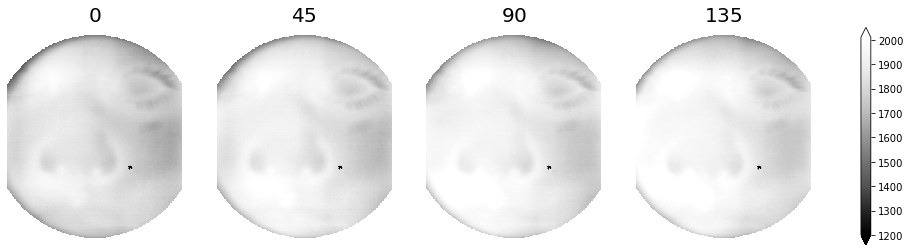

[30.4 30.4 30.4 30.4]


In [743]:
fig, axes = plt.subplots(figsize=(18, 4), ncols=4)

# STOKES IMAGES
# color "mappable" object returned by ax1.imshow
pos1 = axes[0].imshow(np.transpose(ims[0]), cmap='Greys_r', aspect='auto',vmin =vmin ,vmax = vmax)
#fig.colorbar(pos1, ax=ax1,extend='both',label = "ADU")
axes[0].set_title("$0$",fontsize = 20)
axes[0].axis('off')
    
pos2 = axes[1].imshow(np.transpose(ims[1]), cmap='Greys_r', aspect='auto',vmin =vmin ,vmax = vmax)
#fig.colorbar(pos2, ax=ax2,extend='both')
axes[1].set_title("$45$",fontsize = 20)
axes[1].axis('off')

pos3 = axes[2].imshow(np.transpose(ims[2]), cmap='Greys_r', aspect='auto',vmin =vmin ,vmax = vmax)
#fig.colorbar(pos3, ax=ax3,extend='both')
axes[2].set_title("$90$",fontsize = 20)
axes[2].axis('off')

pos4 = axes[3].imshow(np.transpose(ims[3]), cmap='Greys_r', aspect='auto',vmin =vmin ,vmax = vmax)
axes[3].set_title("$135$",fontsize = 20)
axes[3].axis('off')

fig.colorbar(pos1, ax=axes.ravel().tolist(), extend='both')
fig.savefig( '/Volumes/KESU/IRCAM_data/imgs/'+name[:-3]+'flux.png')

plt.show()

print(ts)

<ipython-input-727-12f8777530c6>:12: RuntimeWarning: invalid value encountered in multiply
  AOLP_mask =AOLP*mask;


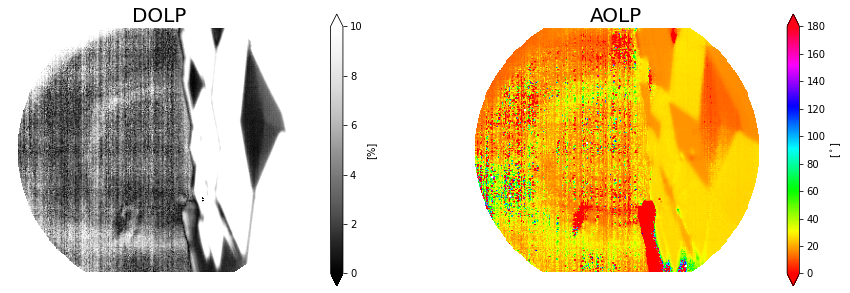

In [727]:
#set clim for S0 image
S0mean = np.mean(S0)
S0std  = np.std(S0)
dev = 3
    
s1m = np.max(np.abs(S1/S0))
s2m = np.max(np.abs(S2/S0)) 

DOLP_mask =DOLP*mask;
DOLP_mask[DOLP_mask == 0] = 'nan' 

AOLP_mask =AOLP*mask;
AOLP_mask[AOLP_mask == 0] = 'nan' 
    
#AOLP DOLP
fig, (ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=2)
# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow


pos2 = ax2.imshow(DOLP_mask, cmap='Greys_r',vmin = 0,vmax = 10)
fig.colorbar(pos2, ax=ax2,extend='both',label = '[%]')
ax2.set_title("DOLP",fontsize = 20)
ax2.axis('off')

pos3 = ax3.imshow(AOLP_mask, cmap='hsv',vmin=0, vmax=180)
fig.colorbar(pos3, ax=ax3,extend='both',label = "[$^\circ$]")
ax3.set_title("AOLP",fontsize = 20)
ax3.axis('off')
plt.show()
fig.savefig( '/Volumes/KESU/IRCAM_data/imgs/daolp_'+name[:-3]+'.png')
    

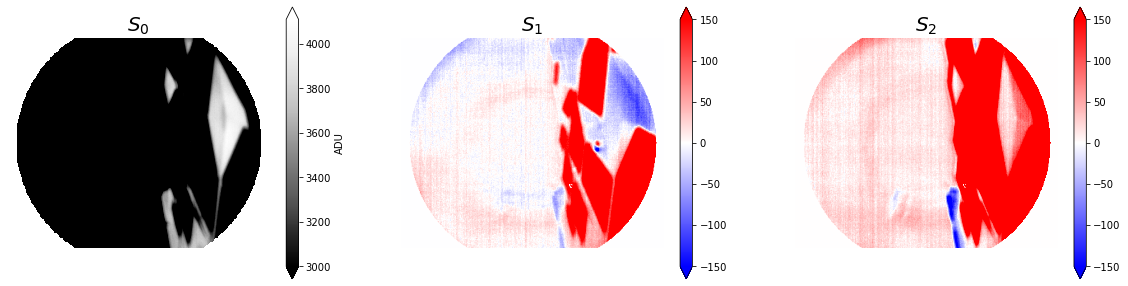

In [728]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 5), ncols=3)

# STOKES IMAGES
# color "mappable" object returned by ax1.imshow
S0_mask =S0*mask;
S0_mask[S0_mask == 0] = 'nan' 
pos1 = ax1.imshow(S0_mask, cmap='Greys_r',vmin = 3000)
fig.colorbar(pos1, ax=ax1,extend='both',label = "ADU")
ax1.set_title("$S_0$",fontsize = 20)
ax1.axis('off')
    
lim = 150;
pos2 = ax2.imshow(S1*mask, cmap='bwr', vmin =-lim,vmax =lim )
fig.colorbar(pos2, ax=ax2,extend='both')
ax2.set_title("$S_1$",fontsize = 20)
ax2.axis('off')

pos3 = ax3.imshow(S2*mask, cmap='bwr', vmin =-lim,vmax =lim)
fig.colorbar(pos3, ax=ax3,extend='both')
ax3.set_title("$S_2$",fontsize = 20)
ax3.axis('off')

fig.savefig( '/Volumes/KESU/IRCAM_data/imgs/stokes_'+name[:-3]+'.png')
plt.show()

### 

In [729]:
def func1(x, a, b, c):
    return a*(x)**c +b

In [730]:
def f_inv(T,a,b,c):
    return ((T-b)/a)**(1/c)

In [731]:
[a,b,c] =  [1.84809871, 1066.34887887,    1.71564497]

In [732]:
sbt = np.zeros([256,320]);
s1bt = np.zeros([256,320]);
s2bt = np.zeros([256,320]);
for i in range(256):
    for j in range(320):
        s0 = S0[i,j]/2;
        s1 = S1[i,j]
        s2 = S2[i,j]
        
        SBT = f_inv(s0,a,b,c)
        sbt[i,j] = SBT
        
        s1bt[i,j] = f_inv(s0+s1/2,a,b,c)- f_inv(s0-s1/2,a,b,c)
        s2bt[i,j] = f_inv(s0+s2/2,a,b,c)- f_inv(s0-s2/2,a,b,c)

<ipython-input-730-f34bbf9c2852>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((T-b)/a)**(1/c)


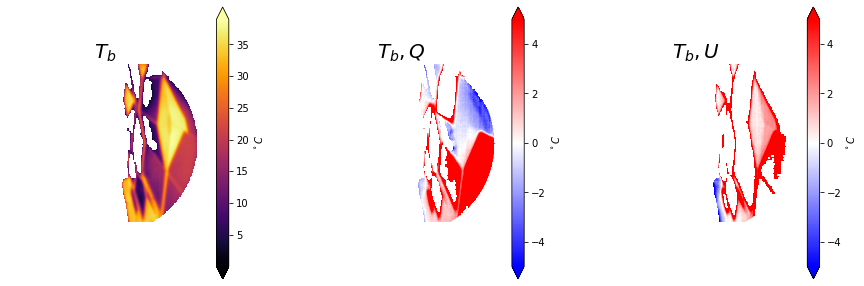

In [733]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)

# STOKES IMAGES
# color "mappable" object returned by ax1.imshow
sbt_mask =sbt*mask;
sbt_mask[sbt_mask == 0] = 'nan' 
pos1 = ax1.imshow(sbt_mask, cmap='inferno')
fig.colorbar(pos1, ax=ax1,extend='both',label = "$^\circ C$")
ax1.set_title("$T_b$",fontsize = 20)
ax1.axis('off')
    
lim = 5;
pos2 = ax2.imshow(s1bt*mask, cmap='bwr', vmin =-lim,vmax =lim )
fig.colorbar(pos2, ax=ax2,extend='both',label = "$^\circ C$")
ax2.set_title("$T_b,Q$",fontsize = 20)
ax2.axis('off')

pos3 = ax3.imshow(s2bt*mask, cmap='bwr', vmin =-lim,vmax =lim)
fig.colorbar(pos3, ax=ax3,extend='both',label = "$^\circ C$")
ax3.set_title("$T_b,U$",fontsize = 20)
ax3.axis('off')

fig.savefig( '/Volumes/KESU/IRCAM_data/imgs/thermal_'+name[:-3]+'.png')
plt.show()